# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [ ]:
# Uncomment and run these in Colab
%tensorflow_version 1.x
!pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random

TensorFlow 1.x selected.
     |████████████████████████████████| 25.0MB 129kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ROLLNUMBER = 21100231
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2500
# Use this to prefix all your paths when reading/writing data to drive.
# BASE_DIR = ''
BASE_DIR = '/content/drive/My Drive/CS437 - Deep Learning/DLAS5/'

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [ ]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = BASE_DIR + 'filtered_emojis/*'
    # base_dir = 'filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

In [ ]:
noise = sample_noise()
(noise[0]).shape

(100,)

### Implementing the Discriminator of the DCGAN
The discriminator in this DCGAN is a convolutional neural network that has the following architecture:
<br>
![DCGAN Discriminator](DCGAN_disc.png)
<br>

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use kernel_size of (4,4), except the last one -- You may change this ((4,4) one) but don't reduce it too much
- Reduce the spatial dimension by a factor of 2 after each convolution, except the last one.
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [ ]:
def build_discriminator():
  input1 = Input(shape=(64,64,3),name='input')
  conv1 = Conv2D(64,kernel_size=(4,4),strides=(2,2),padding='same',use_bias=False,name='conv1')(input1)
  b_n = BatchNormalization(name='batch_normalization1')(conv1)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu1')(b_n)
  conv2 = Conv2D(128,kernel_size=(4,4),strides=(2,2),padding='same',use_bias=False,name='conv2')(leaky_relu)
  b_n = BatchNormalization(name='batch_normalization2')(conv2)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu2')(b_n)
  conv3 = Conv2D(256,kernel_size=(4,4),strides=(2,2),padding='same',use_bias=False,name='conv3')(leaky_relu)
  b_n = BatchNormalization(name='batch_normalization3')(conv3)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu3')(b_n)
  conv4 = Conv2D(512,kernel_size=(4,4),strides=(2,2),padding='same',use_bias=False,name='conv4')(leaky_relu)
  b_n = BatchNormalization(name='batch_normalization4')(conv4)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu4')(b_n)
  conv5 = Conv2D(1,kernel_size=(4,4),padding='same',use_bias=False,name='conv5')(leaky_relu)
  flatten = Flatten()(conv5)
  dense = Dense(1,activation='sigmoid',name='dense')(flatten)
  disc = Model(input=input1,output=dense)           ## disc == discriminator
  disc.name = 'DCGAN_Discriminator'
  disc.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
  return disc
    # pass

In [ ]:
# from keras.utils import plot_model
# disc = build_discriminator()
# disc.summary()
# plot_model(disc,show_shapes=True)

### Implementing the generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator has the following architecture:
<br>
![DCGAN Generator](DCGAN_gen.png)

**Some important points:**
- Pass in use_bias=False,padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the above diagram

Implement the generator in the cell below

In [ ]:
def build_generator():
  # inp = Input((NOISE_DIM,),name='input') 
  model = Sequential()
  model.add(Dense(input_dim=100, output_dim=4*4*1024))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Reshape((4, 4, 1024), input_shape=(4*4*1024,)))
  model.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same',use_bias=False,name='upsample1'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same',use_bias=False,name='upsample2'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same',use_bias=False,name='upsample3'))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=False,name='upsample4'))
  model.add(Activation('tanh'))
  model.name = 'DCGAN_Generator'
  model.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
  return model
    # pass

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [ ]:
def build_gan(gen,disc): 
  disc.trainable = False
  gan = Sequential()
  gan.add(gen)
  gan.add(disc)
  gan.name = 'GAN'
  gan.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
  return gan

Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- Use the provided load_data() function to well... load the data. You can choose between generating Windows or Apple emojis
- The entire data will be loaded as it is small enough to fit into memory (Finally no data generators, right?) BUT you still need to loop over the data in batches. Starter code is provided to you.
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. The code is provided to do this.

In [ ]:
def save_samples(generated_images,step,save_at="samples/"):
  if not os.path.exists(os.path.join(BASE_DIR,save_at)):
    os.mkdir(os.path.join(BASE_DIR,save_at))
  sample_image = create_image_grid(generated_images)
  img = k_image.array_to_img(sample_image)
  img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

In [ ]:
def gan_training_loop(intervals=200):
    # Setup Models here
    generator = build_generator()
    discriminator = build_discriminator()
    discriminator.trainable = False;
    gan = build_gan(generator,discriminator)
    discriminator.trainable = True
    ## generating real labels and fake labels
    y_real = np.ones(shape=(BATCH_SIZE,1))
    y_fake = np.zeros(shape=(BATCH_SIZE,1))
    ## Loading data
    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            real_images = X_train[index:index+BATCH_SIZE,:,:,:]
            noise = sample_noise()
            generated_imgs = np.array(generator.predict_on_batch(noise))
            if not (e % intervals):
                save_samples(generated_imgs,e,'Task-1/With gen batch normalization and concatenating real+fake images/')
            # disc_real_loss,_ = discriminator.train_on_batch(real_images,y_real)
            # disc_fake_loss,_ = discriminator.train_on_batch(generated_imgs,y_fake)
            # disc_loss = (disc_fake_loss + disc_real_loss) * 0.5
            # epoch_disc_loss.append(disc_loss)
            disc_input = np.array(np.concatenate((real_images,generated_imgs),axis=0))
            disc_labels = np.concatenate((y_real,y_fake),axis=0)
            disc_metrics = discriminator.train_on_batch(disc_input,disc_labels)
            disc_loss = disc_metrics[0]
            epoch_disc_loss.append(disc_loss)
            
            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch
            for layers in discriminator.layers:
              layers.trainable = False
            noise = sample_noise()
            gan_metrics = gan.train_on_batch(noise,y_real)
            gen_loss = gan_metrics[0]
            epoch_gen_loss.append(gen_loss)
            # discriminator.trainable = True
            for layers in discriminator.layers:
              layers.trainable = True
            progress_bar.update(i+1)
        if not (e%intervals):
            # Save weights here
            discriminator.save_weights(os.path.join(BASE_DIR,'Task-1/With gen batch normalization and concatenating real+fake images/discriminator'+str(e)),True)
            generator.save_weights(os.path.join(BASE_DIR,'Task-1/With gen batch normalization and concatenating real+fake images/generator'+str(e)),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss


### Training the GAN
We will train a DCGAN to generate fake Apple emojis. 1 epoch should take about 15 seconds on Google Colab.

Train your DCGAN in the below cell

Training Task-1 (Without batch normalization in generator and seperator discriminator training)

In [ ]:
EPOCHS = 1300
d1_loss,g1_loss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


5/5 [==============================] - 9s 2s/step
Epoch: 1 | Discriminator Loss: 2.735327 | Generator Loss: 8.309659
5/5 [==============================] - 1s 218ms/step
Epoch: 2 | Discriminator Loss: 1.186447 | Generator Loss: 13.605331
5/5 [==============================] - 1s 219ms/step
Epoch: 3 | Discriminator Loss: 0.424482 | Generator Loss: 17.170349
5/5 [==============================] - 1s 223ms/step
Epoch: 4 | Discriminator Loss: 0.425989 | Generator Loss: 19.155657
5/5 [==============================] - 1s 221ms/step
Epoch: 5 | Discriminator Loss: 0.591169 | Generator Loss: 17.980061
5/5 [==============================] - 1s 220ms/step
Epoch: 6 | Discriminator Loss: 1.077760 | Generator Loss: 19.082735
5/5 [==============================] - 1s 220ms/step
Epoch: 7 | Discriminator Loss: 0.250633 | Generator Loss: 19.867214
5/5 [==============================] - 1s 222ms/step
Epoch: 8 | Discriminator Loss: 0.512624 | Generator Loss: 15.969986
5/5 [==============================]

Task-1 with concatenating images

In [ ]:
EPOCHS = 100
d2_loss,g2_loss = gan_training_loop(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


5/5 [==============================] - 16s 3s/step
Epoch: 1 | Discriminator Loss: 0.263363 | Generator Loss: 0.064215
5/5 [==============================] - 1s 219ms/step
Epoch: 2 | Discriminator Loss: 0.000179 | Generator Loss: 0.000001
5/5 [==============================] - 1s 220ms/step
Epoch: 3 | Discriminator Loss: 0.000134 | Generator Loss: 0.000001
5/5 [==============================] - 1s 219ms/step
Epoch: 4 | Discriminator Loss: 0.000110 | Generator Loss: 0.000001
5/5 [==============================] - 1s 220ms/step
Epoch: 5 | Discriminator Loss: 0.000092 | Generator Loss: 0.000001
5/5 [==============================] - 1s 219ms/step
Epoch: 6 | Discriminator Loss: 0.000077 | Generator Loss: 0.000001
5/5 [==============================] - 1s 220ms/step
Epoch: 7 | Discriminator Loss: 0.000067 | Generator Loss: 0.000001
5/5 [==============================] - 1s 223ms/step
Epoch: 8 | Discriminator Loss: 0.000058 | Generator Loss: 0.000001
5/5 [==============================] - 1s 

In [ ]:
# import pandas as pd
# pd.DataFrame({'epochs':np.arange(1,1301),'generator_loss':g1_loss,'discriminator_loss':d1_loss}).to_csv("/content/drive/My Drive/CS437 - Deep Learning/DLAS5/Task-1/losses.csv")

### Generating Samples and Analysis

- Plot your discriminator and generator losses and explain how it represents the MiniMax game in play, and comment on the trends you observe.
- Generate random 5 noise samples and their corresponding fake images.
- Mention if you observe any failure modes
- **BONUS (5%):** Try generating some good samples, and try interpolating the input noise samples (Vector Arithmetic) to see if the results are as expected.

In [ ]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

Loss Plot when discriminator training is done seperately on real and fake images

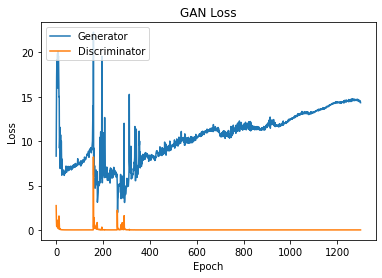

In [ ]:
plot_loss(g1_loss,d1_loss)

Loss Plot when discriminator training is done by concatenating real and fake images

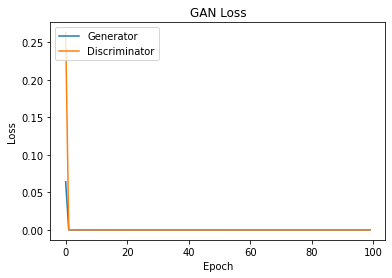

In [ ]:
plot_loss(g2_loss,d2_loss)

Analysis:


> In the above Task-1, we can see from the loss plots that the Generative Adversarial Network is not learning anything since, it is facing a failure mode known as Convergence Failure. In the above former case, when all the above things are kept same while only the discriminator is allowed to train seperately on the (real image, 1) and (fake image,0) tuple datasets, we observe in that case the discriminator loss decreases over epochs which means that discriminator is correctly classifying real images and fake images generated by generator network. In this case, we observe that discriminator dominates over generator and generator is unable to learn the distribution of the real dataset and generate any meaningful images. In the second plot, we observe that both the loss of discriminator and generator approaaches zero when discriminator is trained over a combination of real and fake images. In this case, the possible failure mode is of vanishing gradient which means when discriminator becomes too good at differentiating real and fake samples then, loss function falls to zero and we end up having no gradient to update.



## PART 2: Stablizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (Use the imported RandomNormal function to get weights and pass it in as the kernel_initializer argument in a convolutional layer)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [ ]:
def build_discriminator():
  input1 = Input(shape=(64,64,3),name='input')
  conv1 = Conv2D(64,kernel_size=(4,4),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='conv1')(input1)
  b_n = BatchNormalization(name='batch_normalization1')(conv1)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu1')(b_n)
  conv2 = Conv2D(128,kernel_size=(4,4),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='conv2')(leaky_relu)
  b_n = BatchNormalization(name='batch_normalization2')(conv2)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu2')(b_n)
  conv3 = Conv2D(256,kernel_size=(4,4),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='conv3')(leaky_relu)
  b_n = BatchNormalization(name='batch_normalization3')(conv3)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu3')(b_n)
  conv4 = Conv2D(512,kernel_size=(4,4),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='conv4')(leaky_relu)
  b_n = BatchNormalization(name='batch_normalization4')(conv4)
  leaky_relu = LeakyReLU(alpha=0.2,name='leaky_relu4')(b_n)
  conv5 = Conv2D(1,kernel_size=(4,4),padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='conv5')(leaky_relu)
  flatten = Flatten()(conv5)
  dense = Dense(1,activation='sigmoid',name='dense')(flatten)
  disc = Model(input=input1,output=dense)           ## disc == discrimina
  disc.name = 'DCGAN_Discriminator'
  disc.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
  return disc

In [ ]:
def build_generator():
  model = Sequential()
  # model.add(BatchNormalization())
  # model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(512,(5,5),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='upsample1'))
  # model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(256,(5,5),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='upsample2'))
  # model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='upsample3'))
  # model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3,(5,5),strides=2,padding='same',kernel_initializer=RandomNormal(0.0,0.02),use_bias=False,name='upsample4'))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(Dense(256))
  model.name = 'DCGAN_Generator'
  model.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
  return model

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [ ]:
def normalize(images):
  images = images.astype('float32')
  images = (images - 127.5) / 127.5
  return images

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample fomr a Gaussian distribution.

In [ ]:
def sample_noise():
    return np.reshape(np.random.randn(BATCH_SIZE * NOISE_DIM),(BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [ ]:
# from numpy.random import random
def smooth_real_labels(y):
  return y - 0.3+(np.random.random(y.shape)*0.5)

In [ ]:
y_ones = np.ones((BATCH_SIZE,1))
y = smooth_real_labels(y_ones)
print(y.shape,y.min(),y.max())

(128, 1) 0.7128774543249204 1.1997175047313529


#### Fake Label Smoothing

In [ ]:
# import np.random import random
def smooth_fake_labels(y):
  return y + (0.3 * np.random.random(y.shape))

In [ ]:
y_zeros = np.zeros((BATCH_SIZE,1))
y = smooth_fake_labels(y_zeros)
print(y.shape,y.min(),y.max())

(128, 1) 0.001891833386568953 0.2986323120111562


We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of.

In [ ]:
def gan_training_loop(intervals=200):
    # Setup Models here
    generator = build_generator()
    discriminator = build_discriminator()
    gan = build_gan(generator,discriminator)
    discriminator.trainable = True
    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            real_images = normalize(np.array(X_train[index:index+BATCH_SIZE]))
            y_real = smooth_real_labels(np.ones((BATCH_SIZE,1)))
            fake_images = generator.predict_on_batch(sample_noise())
            y_fake = smooth_fake_labels(np.zeros((BATCH_SIZE,1)))
            if not (e % intervals):
                save_samples(fake_images,e,'Task-2/run-2/') #generated_imgs (Replaced)
            # Discriminator training
            disc_real_loss,_ = discriminator.train_on_batch(real_images,y_real)
            disc_fake_loss,_ = discriminator.train_on_batch(fake_images,y_fake)
            # If you are training the discriminator in two updates, uncomment this
            disc_loss = (disc_fake_loss + disc_real_loss) * 0.5
            epoch_disc_loss.append(disc_loss)
            discriminator.trainable = False
            gan_loss,_ = gan.train_on_batch(sample_noise(),y_real)
            epoch_gen_loss.append(gan_loss)
            discriminator.trainable = True
            progress_bar.update(i+1)
        if not (e%intervals):
            discriminator.save_weights(os.path.join(BASE_DIR+'Task-2/run-2/','discriminator'),True) ## Replace Bonus-Task-10% with Task-2 for task2 
            generator.save_weights(os.path.join(BASE_DIR+'Task-2/run-2/','generator'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [ ]:
EPOCHS = 1500
(d_loss,g_loss) = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


5/5 [==============================] - 8s 2s/step
Epoch: 1 | Discriminator Loss: 0.878296 | Generator Loss: 4.993768
5/5 [==============================] - 1s 220ms/step
Epoch: 2 | Discriminator Loss: 0.974667 | Generator Loss: 8.255629
5/5 [==============================] - 1s 224ms/step
Epoch: 3 | Discriminator Loss: 1.126495 | Generator Loss: 8.084113
5/5 [==============================] - 1s 222ms/step
Epoch: 4 | Discriminator Loss: 1.173984 | Generator Loss: 6.848672
5/5 [==============================] - 1s 222ms/step
Epoch: 5 | Discriminator Loss: 0.989407 | Generator Loss: 7.014207
5/5 [==============================] - 1s 221ms/step
Epoch: 6 | Discriminator Loss: 0.802464 | Generator Loss: 5.451036
5/5 [==============================] - 1s 219ms/step
Epoch: 7 | Discriminator Loss: 0.879176 | Generator Loss: 6.766087
5/5 [==============================] - 1s 225ms/step
Epoch: 8 | Discriminator Loss: 0.538468 | Generator Loss: 4.167156
5/5 [==============================] - 1s 2

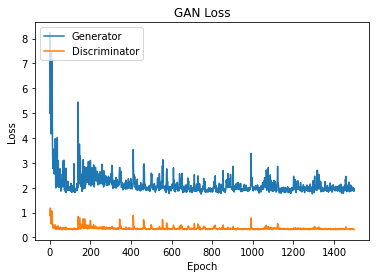

In [ ]:
plot_loss(g_loss,d_loss)

### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images





> For stabilizing the training and convergence of GAN, we used Leaky RElu activation both in generator and discriminator model,using Gaussian Weight initialization with mean=0 and std = 0.02, sampling noise from standard normal distribution, smoothing of labels for real and fake labels, normalization on batch of real images,and seperate training of discriminator both on real and fake images are used. By making these changes, we observed that GAN converges and both generator and discriminator develops equilibrium during training and we observe that the quality of fake images generated by generator improves during training which shows that the generator model started learning the distribution of the emojis. However, the modified generator network is still facing a failure mode i.e. 'Mode Collapse' which means the generator network is not learning all the modes present in the data distribution except, it is learning a few of them and generating images from them. This effect can be observed from the generated fake images.


### Bonus (5%)

In [ ]:
## Sampling noise distribution
# noise = sample_noise()

In [ ]:
''' Saving the generated noise for getting same results as below in fututre '''
# np.save('/content/drive/My Drive/CS437 - Deep Learning/DLAS5/Task-2/noise.npy',noise)
''' Loading saved noise data '''
noise = np.load('/content/drive/My Drive/CS437 - Deep Learning/DLAS5/Task-2/noise.npy')

Training Samples Generation

In [ ]:
## Loading generator weights
generator = build_generator()
generator.load_weights('/content/drive/My Drive/CS437 - Deep Learning/DLAS5/Task-2/generator')
idx = np.array([10,35,30,40,90,5])
samples = []
for i in range(len(idx)):
  samples.append(noise[idx[i]])
samples = np.array(samples)
## Generating samples
generated_image = generator.predict_on_batch(samples)
## showing images
save_samples(generated_image,'training','Task-2/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

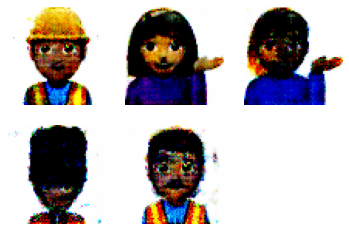

In [ ]:
## Loading generator weights
generator = build_generator()
generator.load_weights('/content/drive/My Drive/CS437 - Deep Learning/DLAS5/Task-2/generator')
idx = np.array([10,35,30,40,90,5])
plt.subplot(2,3,1)
image = (generator.predict(noise[idx[3]].reshape(1,100))).reshape(64,64,3)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,3,2)
image = (generator.predict(noise[idx[4]].reshape(1,100))).reshape(64,64,3)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,3,3)
image = (generator.predict(noise[idx[1]].reshape(1,100))).reshape(64,64,3)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,3,4)
n = noise[idx[3]] - noise[idx[1]] #- noise[idx[4]]
image = (generator.predict(n.reshape(1,100))).reshape(64,64,3)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,3,5)
n = noise[idx[4]] + (noise[idx[3]] - noise[idx[1]])
image = (generator.predict(n.reshape(1,100))).reshape(64,64,3)
plt.imshow(image)
plt.axis('off')


Bonus (5%) Analysis:


> In this task where we need to implement vector arithmetic on noise vectors that are mapped to some good generated images. For this task, we select the three images in the first row generated from randomly sampled gaussian noise using the pre-trained generator network. Now from the noise vectors and these images, we want to generate an image of the girl wearing the helmet and vest of the man/boy of image1. For this, what we can do is to subtract the noise vectors of image1 and image 3 to remove the man and the resulting image is the first image in 2nd row. After that, the resulting noise vectors should be added to 2nd image of the girl in order to acheive more or less our desired image. The final image which our generator network generated, is the last image in 2nd row. In this picture, we get the vest but the network has not generated the image of girl with vest instead, the network generated an image of boy having the outline of the girl and the helmet. The helmet pixels are submerged with the pixel of boy's face. One possible explanation for this image could be that since the posture of both boys in image 1 and 3 have different colours and postures, so they cannot be properly eliminated from the noise vectors and their effect gets dominated over the girl during image generation. 



In [ ]:
import pandas as pd
pd.DataFrame({'epochs':np.arange(1,1501),'generator_loss':g_loss,'discriminator_loss':d_loss}).to_csv("/content/drive/My Drive/CS437 - Deep Learning/DLAS5/Task-2/losses.csv")

## BONUS - 10%
The current training set was a subset of the actual emojis dataset. In the filtering process, most inanimate objects were removed and the focus was on front-facing emojis. Train the model over the full dataset or a subset of your choice and repeat the above analysis

In [ ]:
def load_data():
    base_dir = BASE_DIR + 'Apple/Train/*'
    # base_dir = 'filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

In [ ]:
EPOCHS = 800
(dis_loss,gen_loss) = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


17/17 [==============================] - 10s 616ms/step
Epoch: 1 | Discriminator Loss: 0.328151 | Generator Loss: 1.940432
17/17 [==============================] - 4s 220ms/step
Epoch: 2 | Discriminator Loss: 0.331192 | Generator Loss: 1.979852
17/17 [==============================] - 4s 219ms/step
Epoch: 3 | Discriminator Loss: 0.335542 | Generator Loss: 2.127968
17/17 [==============================] - 4s 219ms/step
Epoch: 4 | Discriminator Loss: 0.327628 | Generator Loss: 1.954102
17/17 [==============================] - 4s 220ms/step
Epoch: 5 | Discriminator Loss: 0.343042 | Generator Loss: 2.032201
17/17 [==============================] - 4s 220ms/step
Epoch: 6 | Discriminator Loss: 0.320258 | Generator Loss: 1.968140
17/17 [==============================] - 4s 220ms/step
Epoch: 7 | Discriminator Loss: 0.326736 | Generator Loss: 2.099213
17/17 [==============================] - 4s 220ms/step
Epoch: 8 | Discriminator Loss: 0.332630 | Generator Loss: 1.993600
17/17 [================

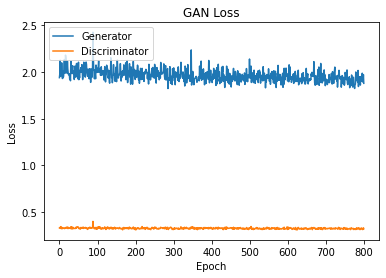

In [ ]:
plot_loss(gen_loss,dis_loss)

Analysis

> In this bonus task, I used the emoji's stored in Apple/Train folder utilizing the structure of GAN of Task-2. The loss plot for this task is similar to the loss plot of Task-2 just shown on a range of 600-1400 epochs. From the loss plot, we can observe that both the generator and discriminator models of GAN have established equilibrium and the generator network is able to generate some meaningful emoji pictures from the random noise from the sampling of standard normal distribution. However, if we look at the generated images, we find that the generator model is facing 'mode collapse' evident from the fact that it has only learnt the distribution of some emoji flags and faces and it is capable of generating images from only those distribution modes.

